In [1]:
import os
import PIL.Image as Image
import torch.cuda
import torchvision.transforms as transforms
import numpy as np

from LookGenerator.datasets.utils import prepare_images_for_encoder, to_array_from_decoder, load_image, convert_channel, show_array_as_image, save_array_as_image
from LookGenerator.networks.encoder_decoder import EncoderDecoder
from LookGenerator.networks.utils import load_model
import cv2

# Загрузка изображений

In [25]:
#root = r"C:\Users\Даша\кто\мусор\zalando-hd-resized\val"
root = r"C:\Users\DenisovDmitrii\Desktop\forEncoder\val"
file_name = r"00006_00"

human_image = load_image(root, r"imageWithNoCloth", file_name, ".png")
clothes = load_image(root, r"cloth", file_name, r".jpg")

pose_points = []
points_list = os.listdir(os.path.join(
    root,
    r"posePoints",
    file_name
))
print(len(points_list))
for pose_point in points_list:
    pose_point_image = convert_channel(load_image(root, os.path.join(r"posePoints", file_name), pose_point, ""))
    pose_points.append(pose_point_image)

# if model dataset has pose_points=False param:
pose_points = []

17


# Определение трансформаций

In [26]:
input_rgb_transform = transforms.Compose([
    transforms.Resize((256, 192)),
    transforms.Normalize(
        mean=[0.5, 0.5, 0.5],
        std=[0.25, 0.25, 0.25]
    )
])

input_bin_transform = transforms.Compose([
    transforms.Resize((256, 192)),
    transforms.Normalize(
        mean=[0.5],
        std=[0.25]
    )
])

# Загрузка весов модели

In [27]:
model_input = prepare_images_for_encoder(human_image, pose_points, clothes, input_rgb_transform, input_bin_transform).float()

C:\Users\DenisovDmitrii\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [28]:
#weights_dir = r"C:\Users\Даша\PycharmProjects\SMBackEnd\LookGenerator\weights\epoch_19.pt"
weights_dir = r"C:\Users\DenisovDmitrii\OneDrive - ITMO UNIVERSITY\peopleDetector\encoder\weights\session13\epoch_19.pt"

In [29]:
model = EncoderDecoder(in_channels=6, out_channels=3)
model = load_model(model, weights_dir)

In [30]:
device = 'cpu' if torch.cuda.is_available() else 'cpu'

model = model.to(device)
model_input = model_input.to(device)

# Прогон модели

In [31]:
model_output = model(model_input)

# Отображение результата

In [32]:
model_output = to_array_from_decoder(model_output)

In [33]:
to_plt = np.array(model_output)

In [34]:
c = np.array(to_plt[:,:,0])
to_plt[:,:,0] = to_plt[:,:,2]
to_plt[:,:,2] = c

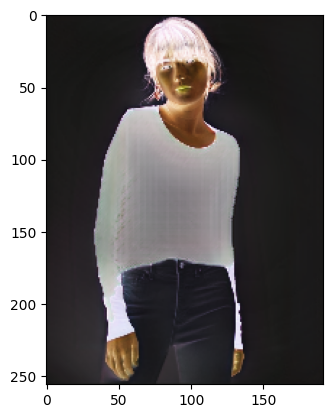

In [46]:
show_array_as_image(np.invert(np.uint8(255*to_plt)))
save_array_as_image(np.uint8(255*model_output), save_path=fr"C:\Users\DenisovDmitrii\Desktop\forEncoder\out\{file_name}.png")
# cv2.imwrite(fr"C:\Users\DenisovDmitrii\Desktop\forEncoder\out\{file_name}.png", cv2.cvtColor(np.uint8(255*model_output), cv2.COLOR_RGB2BGR) )